## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1_l2

#建立神經網路
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_alpha=0.01, l2_alpha=0.01, drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    x = keras.layers.BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu",
                                   kernel_regularizer=l1_l2(l1=l1_alpha, l2=l2_alpha))(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu",
                                   kernel_regularizer=l1_l2(l1=l1_alpha, l2=l2_alpha))(x)
        x = keras.layers.Dropout(drp_ratio)(x)
        x = keras.layers.BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
#設定超參數
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [512]
MOMENTUM = 0.95

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
results = {}
for batch_size in BATCH_SIZE:
    model = build_mlp(input_shape=x_train.shape[1:], output_units=10,
                      num_neurons=[512, 256, 128],
                      l1_alpha=0.001, l2_alpha=0.001, drp_ratio=0.2)
    model.summary()
    model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "batch_size_"+ str(batch_size)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)      

50000/50000 [==============================] - 32s 636us/step - loss: 2.2906 - acc: 0.4429 - val_loss: 2.2163 - val_acc: 0.4612
Epoch 40/50
50000/50000 [==============================] - 24s 471us/step - loss: 2.2769 - acc: 0.4415 - val_loss: 2.1926 - val_acc: 0.4747
Epoch 41/50
50000/50000 [==============================] - 24s 489us/step - loss: 2.2725 - acc: 0.4426 - val_loss: 2.1621 - val_acc: 0.4803
Epoch 42/50
50000/50000 [==============================] - 22s 448us/step - loss: 2.2377 - acc: 0.4474 - val_loss: 2.1463 - val_acc: 0.4756
Epoch 43/50
50000/50000 [==============================] - 24s 484us/step - loss: 2.2187 - acc: 0.4454 - val_loss: 2.1255 - val_acc: 0.4765
Epoch 44/50
50000/50000 [==============================] - 23s 455us/step - loss: 2.1996 - acc: 0.4459 - val_loss: 2.1188 - val_acc: 0.4794
Epoch 45/50
50000/50000 [==============================] - 26s 521us/step - loss: 2.1842 - acc: 0.4498 - val_loss: 2.1021 - val_acc: 0.4728
Epoch 46/50
50000/50000 [=======

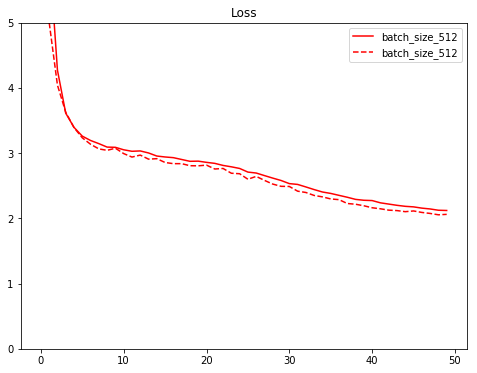

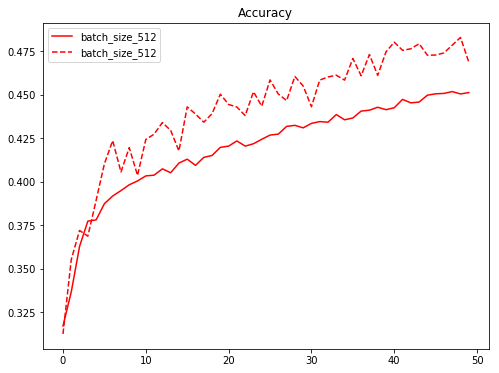

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()
